## Data Science Blogpost

*Author: Dominik Jung (dominik.jung2@porsche.de)*

### Import packages

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import tree

### 1. Data selection and preprocessing

Load the raw csv file into the python workspace to investigate it further:

In [119]:
dataset = pd.read_csv("titanic.csv")

Take a deeper look at the dataset

In [120]:
dataset.head(6)

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q


In [134]:
dataset.dtypes

survived      int64
pclass        int64
age         float64
sibsp         int64
parch         int64
ticket       object
fare        float64
embarked     object
female        int64
dtype: object

In [122]:
dataset.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


As we can see the mean age of the passengers was about 30 years with a sd of 14.5 years. The interquartile range is between 20 and 38 years, indicating that 50% of the passengers were in this age range. The oldest passenger was 76 years old

<AxesSubplot:>

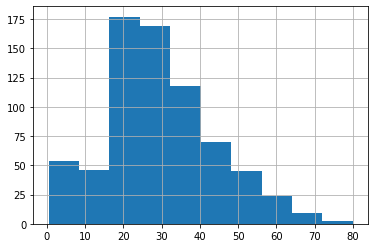

In [123]:
dataset.age.hist()

<AxesSubplot:ylabel='sex'>

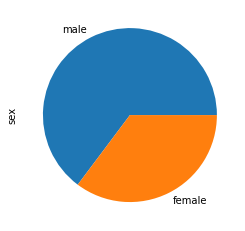

In [124]:
dataset.sex.value_counts().plot(kind = 'pie')

As we can see there are more male than female passengers on board. But if we take a look at the survival rates we see that females had a much higher survivial chance:

<AxesSubplot:title={'center':'survived'}, xlabel='sex'>

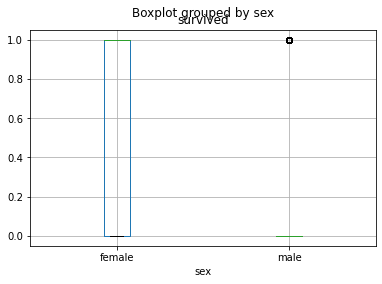

In [125]:
dataset.boxplot(column="survived", by="sex")

In [126]:
dataset.groupby("sex").survived.value_counts()

sex     survived
female  1           233
        0            81
male    0           468
        1           109
Name: survived, dtype: int64

In [127]:
print("Female Rate: " + str(81/233) +"\nMale Rate: "+ str(109/468))

Female Rate: 0.34763948497854075
Male Rate: 0.2329059829059829


## 2. Analytics

Based on these findings I would like to investigate what the most influencial factors on survival are. This will help me to survive a shipping accident.

In [128]:
# check missing values in train data
dataset.isnull().sum()

survived      0
pclass        0
name          0
sex           0
age         177
sibsp         0
parch         0
ticket        0
fare          0
cabin       687
embarked      2
dtype: int64

In [129]:
# handle missing data
dataset["age"] = dataset["age"].fillna(dataset["age"].median()) # mean would be possible too
dataset["fare"] = dataset["fare"].fillna(dataset["fare"].median())
dataset["embarked"] = dataset["embarked"].fillna(dataset["embarked"].mode())

# remove cabin due to many missing values
dataset = dataset.drop("cabin", 1)

# remove name because model can not handle it
dataset = dataset.drop("name", 1)

dataset.head()

,survived,pclass,sex,age,sibsp,parch,ticket,fare,embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1,1,female,35.0,1,0,113803,53.1000,S
4,0,3,male,35.0,0,0,373450,8.0500,S


In [130]:
# convert to numeric
dataset['sex'] = dataset['sex'].fillna('ffill')
dataset['female'] = [1 if i =='female' else 0 for i in dataset['sex']]
dataset = dataset.drop("sex", 1)

In [131]:
dataset.head()

,survived,pclass,age,sibsp,parch,ticket,fare,embarked,female
0,0,3,22.0,1,0,A/5 21171,7.2500,S,0
1,1,1,38.0,1,0,PC 17599,71.2833,C,1
2,1,3,26.0,0,0,STON/O2. 3101282,7.9250,S,1
3,1,1,35.0,1,0,113803,53.1000,S,1
4,0,3,35.0,0,0,373450,8.0500,S,0


In [132]:
dataset[["pclass", "female", "age", "fare"]]

,pclass,female,age,fare
0,3,0,22.0,7.2500
1,1,1,38.0,71.2833
2,3,1,26.0,7.9250
3,1,1,35.0,53.1000
4,3,0,35.0,8.0500
...,...,...,...,...
886,2,0,27.0,13.0000
887,1,1,19.0,30.0000
888,3,1,28.0,23.4500
889,1,0,26.0,30.0000


### Simple decision tree

In [136]:
clf = DecisionTreeClassifier(max_leaf_nodes=3)
#clf = clf.fit(X_train, Y_train)
clf = clf.fit(dataset[["pclass", "female", "age", "fare"]], dataset["survived"])

## Evaluation

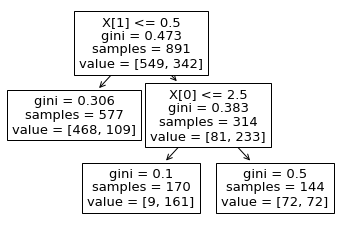

In [137]:
tree.plot_tree(clf)
plt.show()